In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d ravirajsinh45/real-life-industrial-dataset-of-casting-product

Dataset URL: https://www.kaggle.com/datasets/ravirajsinh45/real-life-industrial-dataset-of-casting-product
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
  0% 0.00/100M [00:00<?, ?B/s]
100% 100M/100M [00:00<00:00, 1.22GB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/real-life-industrial-dataset-of-casting-product.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, mixed_precision

# Using image_dataset_from_directory instead of ImageDataGenerator
batch_size = 64

raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/casting_data/casting_data/train',
    validation_split=None,
    image_size=(300, 300),
    batch_size=batch_size,
    color_mode='grayscale',
    label_mode='binary'
)
class_names = raw_train_ds.class_names

raw_test_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/casting_data/casting_data/test',
    image_size=(300, 300),
    batch_size=batch_size,
    color_mode='grayscale',
    label_mode='binary'
)

# Normalization Layer (Built into the pipeline)
normalization_layer = layers.Rescaling(1./255)

train_ds = raw_train_ds.map(lambda x, y: (normalization_layer(x), y))
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = raw_test_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 6633 files belonging to 2 classes.
Found 715 files belonging to 2 classes.


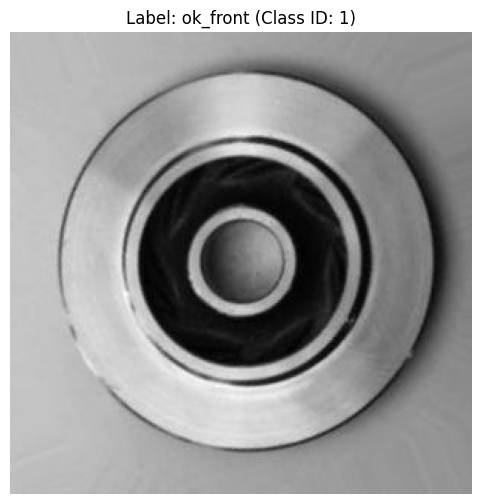

Image Shape: (300, 300, 1)


In [ ]:
# Checking the grayscale image to make the shadow and texture more clear

import matplotlib.pyplot as plt

# It's a list like ['def_front', 'ok_front'], where the index corresponds to the class ID.
label_map = {i: name for i, name in enumerate(class_names)}

images_batch, labels_batch = next(iter(train_ds))

# Pick the first image in the batch
image = images_batch[0]
label = int(labels_batch[0])

# Display it
plt.figure(figsize=(6, 6))

plt.imshow(image.numpy().reshape(300, 300), cmap='gray')y

plt.title(f"Label: {label_map[label]} (Class ID: {label})")
plt.axis("off")
plt.show()

print(f"Image Shape: {image.shape}")

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

In [ ]:
from tensorflow.keras import layers, models

model = models.Sequential([
    # Layer 1: Catch big features (Edge of the impeller)
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(300, 300, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'),

    # Layer 2: Catch textures (Roughness)
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'),

    # Reducing Parameters
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'),


    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'),

    # Layer 3: Catch fine details (Tiny blow holes)
    layers.Conv2D(128, (3,3), padding='same', activation = 'relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'),


    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),

    # OUTPUT LAYER:
    # Sigmoid is perfect for "Pass vs Fail" (0.0 to 1.0)
    layers.Dense(1, activation='sigmoid')
                       ])

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 300, 300, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 300, 300, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 150, 150, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 150, 150, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 75, 75, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 37, 37, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 37, 37, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 18, 18, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 18, 18, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     1,327,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,503,489 (5.74 MB)

 Trainable params: 1,502,785 (5.73 MB)

 Non-trainable params: 704 (2.75 KB)

In [ ]:
model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall(name='recall')]) # using recall as avoiding false negatives is more important than accuracy

In [ ]:
history = model.fit(train_ds, epochs=10, validation_data=test_ds)

Epoch 1/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 43s 288ms/step - accuracy: 0.7226 - loss: 0.9608 - recall: 0.6838 - val_accuracy: 0.6336 - val_loss: 0.6365 - val_recall: 0.0000e+00
Epoch 2/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 19s 186ms/step - accuracy: 0.9374 - loss: 0.1635 - recall: 0.9382 - val_accuracy: 0.6378 - val_loss: 0.6753 - val_recall: 0.1412
Epoch 3/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 19s 186ms/step - accuracy: 0.9763 - loss: 0.0689 - recall: 0.9747 - val_accuracy: 0.6769 - val_loss: 0.5497 - val_recall: 0.2366
Epoch 4/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 19s 186ms/step - accuracy: 0.9872 - loss: 0.0432 - recall: 0.9884 - val_accuracy: 0.7566 - val_loss: 0.6612 - val_recall: 0.4733
Epoch 5/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 19s 186ms/step - accuracy: 0.9775 - loss: 0.0676 - recall: 0.9822 - val_accuracy: 0.6545 - val_loss: 1.5427 - val_recall: 0.1527
Epoch 6/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 19s 186ms/step - accuracy: 0.9878 - loss: 0.0320 - recall: 0.9894 - val_accuracy: 0.9860 - val_loss: 0.0461 - v

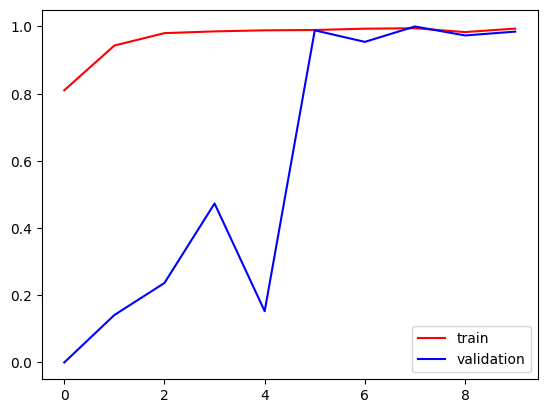

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['recall'],color='red',label='train')
plt.plot(history.history['val_recall'],color='blue',label='validation')
plt.legend()
plt.show()

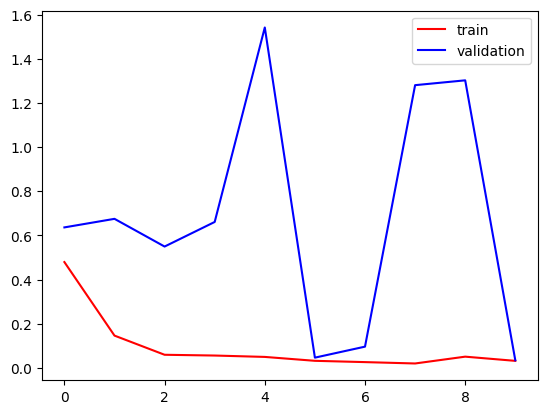

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

Found 715 files belonging to 2 classes.
Running diagnostic on test set...
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step

--- ENGINEERING CLASSIFICATION REPORT ---
               precision    recall  f1-score   support

Defective (0)       0.99      0.99      0.99       453
       OK (1)       0.98      0.98      0.98       262

     accuracy                           0.99       715
    macro avg       0.99      0.99      0.99       715
 weighted avg       0.99      0.99      0.99       715



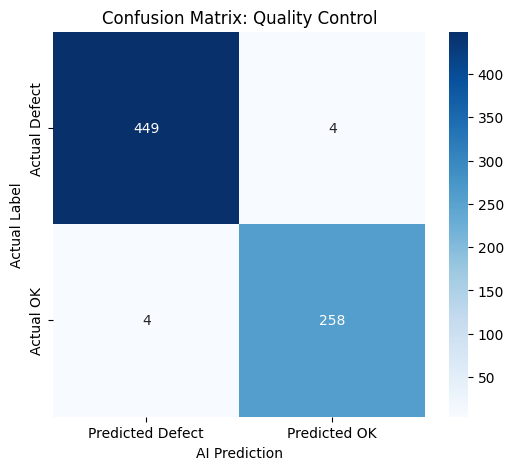

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

test_ds_eval = tf.keras.utils.image_dataset_from_directory(
    '/content/casting_data/casting_data/test',
    image_size=(300, 300),
    batch_size=32,
    color_mode='grayscale',
    label_mode='binary',
    shuffle=False
)

# Apply the same normalization
normalization_layer = layers.Rescaling(1./255)
test_ds_eval = test_ds_eval.map(lambda x, y: (normalization_layer(x), y))

# Predict
print("Running diagnostic on test set...")
predictions = model.predict(test_ds_eval)
y_pred = (predictions > 0.5).astype(int) # Convert probabilities to 0 or 1

# Get True Labels
y_true = np.concatenate([y for x, y in test_ds_eval], axis=0)

# Generate Report
print("\n--- ENGINEERING CLASSIFICATION REPORT ---")
print(classification_report(y_true, y_pred, target_names=['Defective (0)', 'OK (1)']))

# Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Defect', 'Predicted OK'],
            yticklabels=['Actual Defect', 'Actual OK'])
plt.ylabel('Actual Label')
plt.xlabel('AI Prediction')
plt.title('Confusion Matrix: Quality Control')
plt.show()

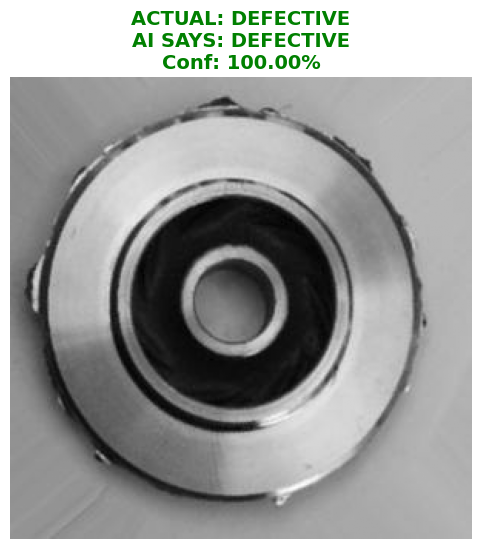

Pixel Range: Min=0.00, Max=1.00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

images, labels = next(iter(test_ds))

idx = random.randint(0, len(images) - 1)
sample_image = images[idx]
sample_label = int(labels[idx])

input_img = np.expand_dims(sample_image, axis=0)
prediction_score = model.predict(input_img, verbose=0)[0][0]

if prediction_score > 0.5:
    predicted_class = 1 # OK
    confidence = prediction_score * 100
else:
    predicted_class = 0 # Defective
    confidence = (1 - prediction_score) * 100

class_names = {0: 'DEFECTIVE', 1: 'OK'}
actual_class = class_names[sample_label]
ai_decision = class_names[predicted_class]

# We verify the range. If max is 1.0, we multiply by 255 to make it visible.
display_image = sample_image.numpy()
if display_image.max() <= 1.0:
    display_image = (display_image * 255).astype("uint8")
else:
    display_image = display_image.astype("uint8")

# VISUALIZE
plt.figure(figsize=(6, 6))
plt.imshow(display_image.reshape(300, 300), cmap='gray')
plt.axis('off')

# Colors
color = 'green' if predicted_class == sample_label else 'red'

plt.title(f"ACTUAL: {actual_class}\nAI SAYS: {ai_decision}\nConf: {confidence:.2f}%",
          color=color, fontsize=14, fontweight='bold')
plt.show()

# Debug Info
print(f"Pixel Range: Min={sample_image.numpy().min():.2f}, Max={sample_image.numpy().max():.2f}")

In [ ]:
# Save the entire model (architecture + weights)
model.save('casting_defects_model.keras')

print("Model saved successfully as 'casting_defects_model.keras'")

Model saved successfully as 'casting_defects_model.keras'
